In [50]:
import matplotlib.pyplot as plt
import numpy as np

pb_convert = 3.894E8 # conversion factor GeV^-2 -> pb
MZ = 91.188    # Z boson mass
GAMMAZ = 2.4414 # Z boson width
alpha = 1/132.507 # alpha QED
Gfermi = 1.16639E-5 # fermi constant
sw2 = 0.222246 # sin^2(weinberg angle)

# e+e- COM energy in GeV
ECM = 90
hats = ECM ** 2

import vegas
import numpy as np
import gvar

@vegas.batchintegrand
def f_batch(x):
    # evaluate integrand at multiple points simultaneously
    dim = x.shape[1]
    dx = 0.0
    for d in range(dim):
        dx += x[:, d]
    return ((np.pi * 2 * alpha ** 2) / (4 * hats)) * (1 + dx ** 2)

integ = vegas.Integrator(1 * [[-1,1]]) # control range of points and dimensions
integral = 0.0
variance = 0.0
for x, wgt, hcube in integ.random_batch(yield_hcube=True):
    wgt_fx = wgt * f_batch(x)
    # iterate over hypercubes: compute variance for each,
    #                          and accumulate for final result
    for i in range(hcube[0], hcube[-1] + 1):
        idx = (hcube == i)
        # select array items for h-cube i
        nwf = np.sum(idx)           # number of points in h-cube i, True = 1, Flase = 0
        wf = wgt_fx[idx]
        sum_wf = np.sum(wf)         # sum of wgt * f(x) for h-cube i
        sum_wf2 = np.sum(wf ** 2)   # sum of (wgt * f(x)) ** 2
        integral += sum_wf
        variance += (sum_wf2 * nwf - sum_wf ** 2) / (nwf - 1.)
        
# answer = integral;   standard deviation = variance ** 0.5
result = gvar.gvar(integral, variance ** 0.5)
analytic = (4 * np.pi * alpha ** 2) / (3 * hats)

# don't forget to convert the GeV^-2 to pb! 
print('cross-section = '+str(result.mean * pb_convert)+' +/ '+str(result.sdev * pb_convert)+' pb')
print('analytical cross-section = '+str(analytic * pb_convert)+' pb')

cross-section = 11.469190422562983 +/ 0.0014615466166521046 pb
analytical cross-section = 11.468903393827555 pb


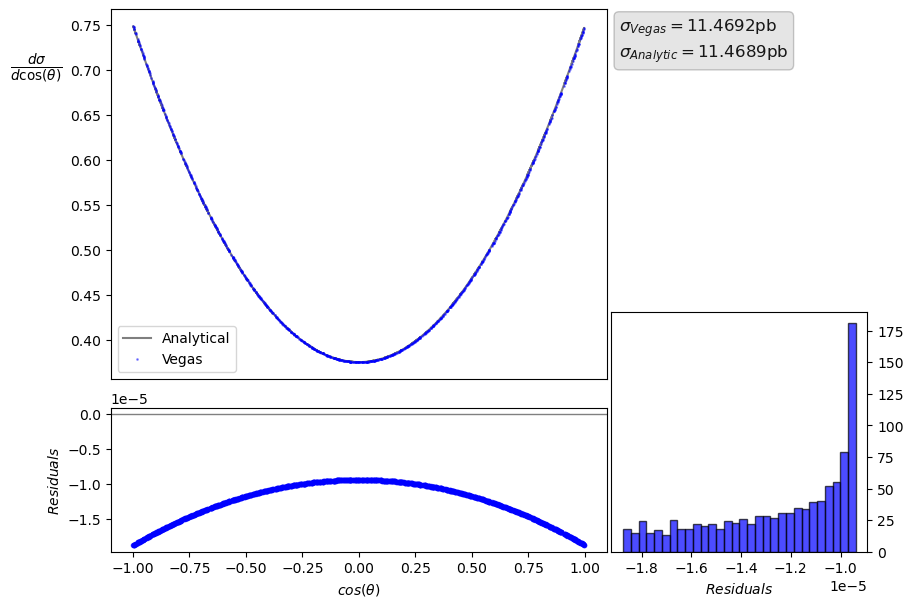

In [106]:
def func(n, x):
    return n * (1 / analytic) * (1 + x ** 2)

fig, ax = plt.subplots()

y = func((np.pi * alpha ** 2) / (2 * hats), x.flatten()) 

ax.plot(x.flatten(), y, color = 'black', alpha = 0.5, label = 'Analytical')
ax.plot(x.flatten(), f_batch(x) * (1 / result.mean), color = 'blue', alpha = 0.4, 
            marker = '.', ls = 'None', markersize = 2, label = 'Vegas')
ax.axes.get_xaxis().set_visible(False)
plt.ylabel(r'$\frac{d\sigma}{d\cos(\theta)}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.8)
plt.legend()

textstr = '\n'.join((
    r'$\sigma_{Vegas}=$' +str(round(result.mean * pb_convert, 4))+ 'pb',
    r'$\sigma_{Analytic}=$' +str(round(analytic * pb_convert, 4))+ 'pb'))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

residuals = f_batch(x) * (1 / result.mean) - y
ax2 = plt.figure(1).add_axes([0.9075, -0.25, 0.4, 0.5])
plt.hist(residuals, bins = 30, color = 'blue', edgecolor = 'black', alpha = 0.7)
ax2.yaxis.tick_right()
plt.xlabel('$Residuals$')

plt.figure(1).add_axes([0.125, -0.25, 0.775, 0.3])
plt.axhline(y = 0, color = 'gray', linewidth = 1)
plt.scatter(x, residuals, marker = '.', color = 'blue', alpha = 0.7)
plt.ylabel('$Residuals$')
plt.xlabel(r'$cos(\theta)$')
plt.show()

In [ ]:
# we will store "generated" costh in an array:
costh_P = []
rap_P = []
ptrans_P = []
# required Number of events to generate
Neve = 10 ** 3
# a counter of events generated in the loop
jj = 0
# start generating events (i.e. "hit or miss") 
# jj counts the events, so stay in this loop until we have generated the required number
while jj < Neve:
    sys.stdout.write("progress: %d%%   \r" % (float(jj)*100./(Neve)) )
    sys.stdout.flush()
    costh_ii = -1 + random.random() * 2
    w_ii = dsigma(costh_ii) * 2

    # Divide the weight by the maximum weight stored in the integration step
    # this will create a "probability for the event.
    prob = w_ii / w_max
    rand_num = random.random()

    # compare to a random number
    # and accept or reject the event
    # according to the hit-or-miss algorithm
    # if the random number is less than the probability of the PS point
    # accept
    if rand_num < prob:
        costh_P += [costh_ii]
        jj = jj + 1
        # the process is phi-symm, so random phi is appropriate
        phi = random.random() * 2 * np.pi
        cosphi = np.cos(phi)
        sinphi = np.sin(phi)
        sinth = np.sqrt(1 - costh_ii ** 2)
        pem = [ 0.5 * ECM, 0., 0., 0.5 * ECM ]
        pep = [ 0.5 * ECM, 0., 0., - 0.5 * ECM ]
        pmm = [ 0.5 * ECM, 0.5 * ECM * sinth * cosphi, 0.5 * ECM * sinth * sinphi, 0.5 * ECM * costh_ii ]
        #pmml = [ 0.5 * ECM, -0.5 * ECM * sinth * cosphi, -0.5 * ECM * sinth * sinphi, -0.5 * ECM * costh_ii ] #lower index
        pmp = [ 0.5 * ECM, - 0.5 * ECM * sinth * cosphi, - 0.5 * ECM * sinth * sinphi, - 0.5 * ECM * costh_ii ]
        #pmpl = [ 0.5 * ECM, 0.5 * ECM * sinth * cosphi, 0.5 * ECM * sinth * sinphi, 0.5 * ECM * costh_ii ] #lower index
        theta = np.arccos(costh_ii)
        psuerap = -np.log(np.tan(0.5 * theta))
        rap_P += [psuerap]
        ptrans = np.sqrt(pmm[1] ** 2 + pmm[2] ** 2)
        ptrans_P += [ptrans]